# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Import your chosen baseline model
# Example: from sklearn.linear_model import LogisticRegression


## Model Choice

We started out with a very easy baeline model that just guesses the forecast of the next 15 Minutes based on the last 15 minutes


In [28]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
df = pd.read_csv('../Data/Load_cleaned.csv')
df.head()

,Unnamed: 0,from,to,load,residual,pumped,time,month,weekday,hour
0,0,01.11.2018 00:00,01.11.2018 01:00,48879.50,34530.00,"3295,75",2018-11-01 00:00:00,11,3,0
1,1,01.11.2018 01:00,01.11.2018 02:00,47312.50,33605.50,"3848,00",2018-11-01 01:00:00,11,3,1
2,2,01.11.2018 02:00,01.11.2018 03:00,46093.75,32232.00,"4452,25",2018-11-01 02:00:00,11,3,2
3,3,01.11.2018 03:00,01.11.2018 04:00,46710.50,33261.75,"4855,75",2018-11-01 03:00:00,11,3,3
4,4,01.11.2018 04:00,01.11.2018 05:00,47624.25,33987.75,"3854,50",2018-11-01 04:00:00,11,3,4


In [29]:
# Ensure time is parsed as datetime and set as index
df['time'] = pd.to_datetime(df['time'])  # Convert 'time' column to datetime
df.set_index('time', inplace=True)      # Set the datetime column as index

# Subset the last 1 years for faster computation
df_subset = df['2023':'2024']  # This will now work since the index is a DatetimeIndex
load_data = df_subset['load']  # Extract the 'load' column


In [33]:
# Determine the split index based on 80% training and 20% test
split_index = int(len(load_data) * 0.8)

# Split the data into train and test sets
train, test = load_data.iloc[:split_index], load_data.iloc[split_index:]

In [35]:
train

time
2023-01-01 00:00:00    38741.00
2023-01-01 01:00:00    38156.00
2023-01-01 02:00:00    37307.00
2023-01-01 03:00:00    36290.75
2023-01-01 04:00:00    35840.00
                         ...   
2024-06-19 20:00:00    55065.75
2024-06-19 21:00:00    52870.75
2024-06-19 22:00:00    51457.00
2024-06-19 23:00:00    48426.25
2024-06-20 00:00:00    45231.75
Name: load, Length: 12864, dtype: float64

In [36]:
result = adfuller(train)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -11.404174248322548
p-value: 7.520177973449421e-21


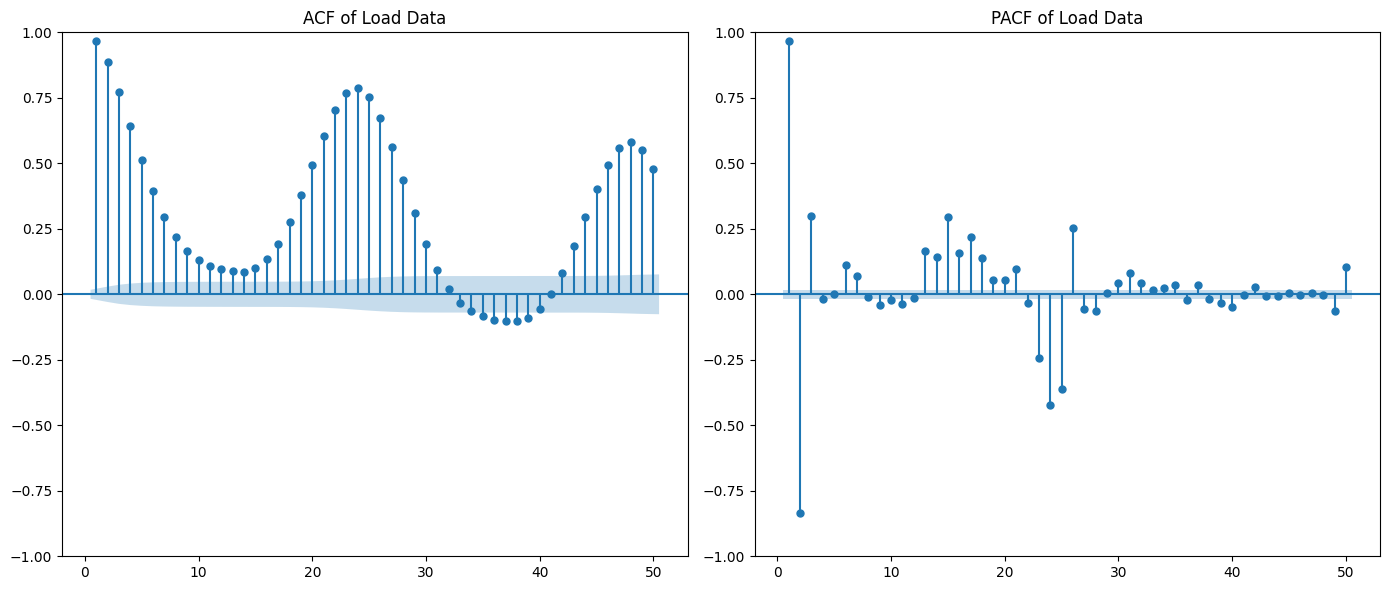

In [37]:
# Plot ACF and PACF
plt.figure(figsize=(14, 6))

# ACF
plt.subplot(1, 2, 1)
plot_acf(train, lags=50, zero=False, ax=plt.gca())
plt.title("ACF of Load Data")

# PACF
plt.subplot(1, 2, 2)
plot_pacf(train, lags=50, zero=False, method='ywm', ax=plt.gca())
plt.title("PACF of Load Data")

plt.tight_layout()
plt.show()

## Implementation

Split the data and start the naive forecast model


In [38]:
# Split into train and test
train_size = int(len(load_data) * 0.8)
train, test = load_data[:train_size], load_data[train_size:]

In [49]:
# Define SARIMA parameters based on provided results
p, d, q = 2, 0, 4  # Non-seasonal components
P, D, Q, s = 2, 1, 0, 24  # Seasonal components with daily period (24 hours)

# Define and fit the SARIMAX model on the training data
mod = sm.tsa.statespace.SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_result_2 = mod.fit(disp=False)

# Summary of the fitted model
print(sarima_result_2.summary())


c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting 

                                      SARIMAX Results                                      
Dep. Variable:                                load   No. Observations:                12864
Model:             SARIMAX(2, 0, 4)x(2, 1, [], 24)   Log Likelihood             -105179.410
Date:                             Tue, 26 Nov 2024   AIC                         210376.821
Time:                                     18:41:18   BIC                         210443.963
Sample:                                          0   HQIC                        210399.268
                                           - 12864                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7017      0.274      6.203      0.000       1.164       2.239
ar.L2         -0.7135      

In [9]:
# model_auto = auto_arima(train[:2000],m = 24, max_p = 10, max_q = 10, max_d = 2, seasonal= True, D= 1,
#                         max_order = 10)

In [10]:
# model_auto.summary()

## Evaluation

[Clearly state what metrics you will use to evaluate the model's performance. These metrics will serve as a starting point for evaluating more complex models later on.]



In [ ]:
# Forecasting the test data (let's assume the length of test data is len(test))
forecast = sarima_result_2.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

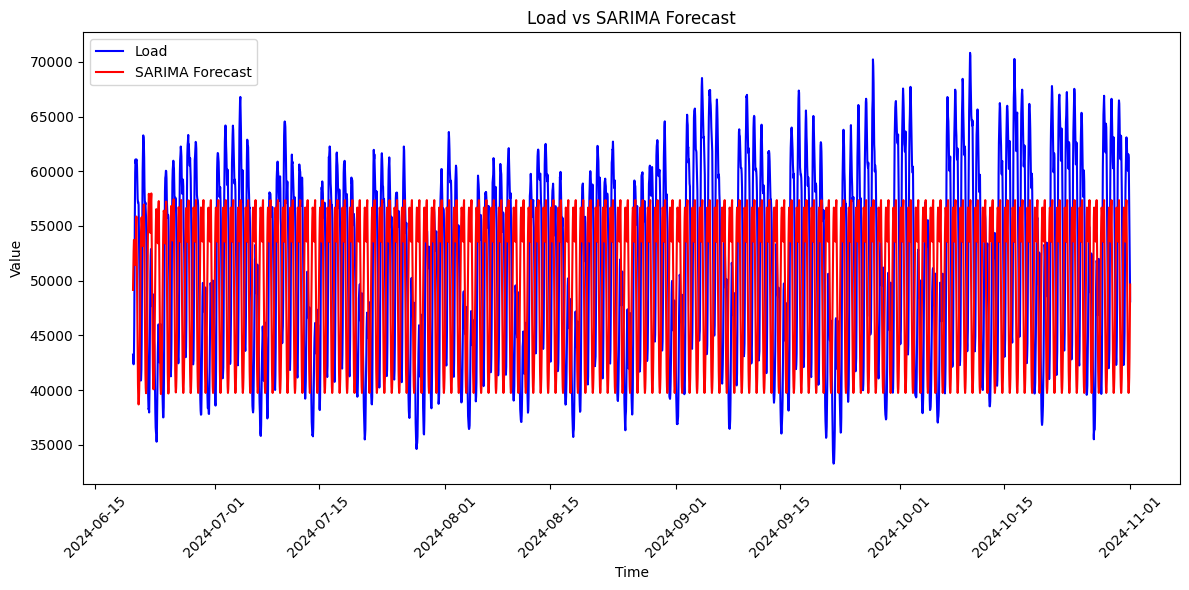

In [58]:
plt.figure(figsize=(12, 6))

# Plotting 'load'
plt.plot(test['time'], test['load'], color='blue', label='Load')

# Plotting 'SARIMA_Forecast'
plt.plot(test['time'], test['SARIMA_Forecast'], color='red', label='SARIMA Forecast')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Load vs SARIMA Forecast')

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot()

c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


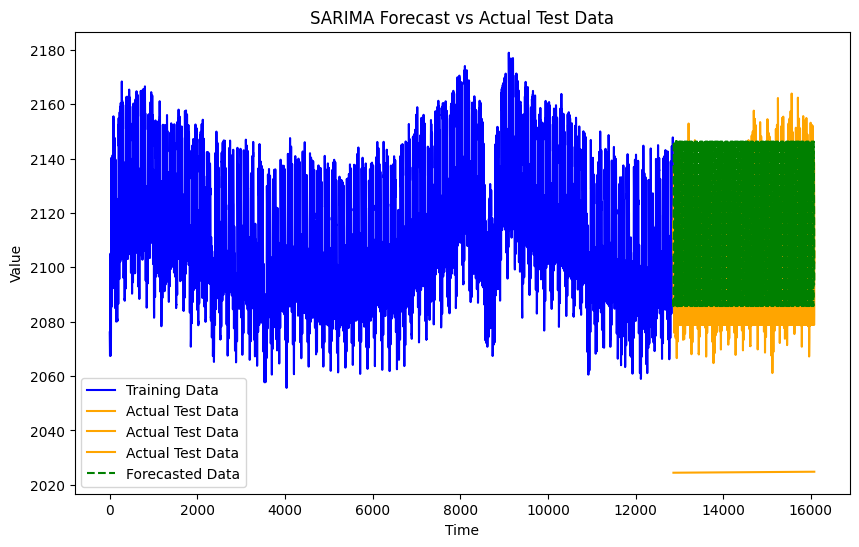

In [ ]:


# Plotting the training data, actual test data, and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(range(len(train)), train, label='Training Data', color='blue')
plt.plot(range(len(train), len(train) + len(test)), test, label='Actual Test Data', color='orange')
plt.plot(range(len(train), len(train) + len(test)), forecast, label='Forecasted Data', color='green', linestyle='--')

# Adding labels and title
plt.title('SARIMA Forecast vs Actual Test Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()
